# Problem Part 1

Autonomous vehicles (AV) and intelligent transport systems (ITS) are the future of road
transport. Automatic detection of vehicles on the road in real-time is essential for vehicle
tracking, vehicle counting, and road incident response.

#### Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import shutil
from PIL import Image
import yaml

In [2]:
tf.__version__

'2.16.2'

#### Set Directory paths and Constants

In [3]:
part1_dir = "Capstone1/Part1"
current_directory = os.getcwd()
images_dir = os.path.join(part1_dir,"Images")
output_dir = os.path.join(current_directory,"yolo_dataset")  # where YOLO-ready dataset will be created
test_size = 0.2         # 80% train, 20% val
random_state = 42

#### Read the labels.csv to find out what each image represents

In [4]:
labels = pd.read_csv(os.path.join(part1_dir, "labels.csv"), header=None, dtype={0: str})
labels.head()

,0,1,2,3,4,5
0,00000000,pickup_truck,213,34,255,50
1,00000000,car,194,78,273,122
2,00000000,car,155,27,183,35
3,00000000,articulated_truck,43,25,109,55
4,00000000,car,106,32,124,45


In [5]:
# Assign column names manually
labels.columns = ["filename", "type","xmin","ymin","xmax","ymax"]
labels.head()

,filename,type,xmin,ymin,xmax,ymax
0,00000000,pickup_truck,213,34,255,50
1,00000000,car,194,78,273,122
2,00000000,car,155,27,183,35
3,00000000,articulated_truck,43,25,109,55
4,00000000,car,106,32,124,45


In [6]:
# Create label mapping
labels_vals = labels['type'].unique()
labels_vals

array(['pickup_truck', 'car', 'articulated_truck', 'bus',
       'motorized_vehicle', 'work_van', 'single_unit_truck', 'pedestrian',
       'bicycle', 'non-motorized_vehicle', 'motorcycle'], dtype=object)

In [7]:
labels.shape

(351549, 6)

#### Filter out labels.csv to only contain data for which we have images

In [8]:
def drop_missing_images_from_csv(df, images_dir):
 # Get available image basenames (without extension)
  valid_images = [os.path.splitext(f)[0] for f in os.listdir(images_dir)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

  # Filter rows to only those where filename exists in images folder
  df_filtered = df[df['filename'].isin(valid_images)].copy()

  print("Original rows:", len(df))
  print("Filtered rows:", len(df_filtered))
  print("Dropped rows:", len(df) - len(df_filtered))
  return df_filtered


In [9]:
#Filtered list
df = drop_missing_images_from_csv(labels, images_dir)
df.shape

Original rows: 351549
Filtered rows: 17967
Dropped rows: 333582


(17967, 6)

The data size is now reduced to 17967 rows

#### Update filenames from labels.csv to include extension

In [10]:
#Update the filenames to match the image names, since filename in the labels.csv is missing the extension
image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

basename_to_file = {os.path.splitext(f)[0]: f for f in image_files}
# Replace filenames in df with actual files (with extension)
df['filename'] = df['filename'].map(basename_to_file)
df['filename'].unique()


array(['00000000.jpg', '00000001.jpg', '00000002.jpg', ...,
       '00005655.jpg', '00005656.jpg', '00005657.jpg'], dtype=object)

#### Checking for duplicates with same values, and priting the images with multiple objects

In [11]:
def check_duplicates(df):

  # ✅ Check 1: exact duplicate rows
  dup_rows = df[df.duplicated()]
  print("Number of exact duplicate rows:", len(dup_rows))


  # ✅ Check 2: same image + same label + same bounding box
  dup_boxes = df[df.duplicated(subset=["filename", "type", "xmin", "ymin", "xmax", "ymax"])]
  print("\nNumber of duplicate bounding boxes:", len(dup_boxes))

  # ✅ Check 3: multiple entries per image (not necessarily bad, just FYI)
  dup_images = df['filename'].value_counts()
  print("\nImages with more than 1 object:")
  print(dup_images[dup_images > 1])


In [12]:
#Displays the image files and number of objects present in them
check_duplicates(df)

Number of exact duplicate rows: 0

Number of duplicate bounding boxes: 0

Images with more than 1 object:
filename
00005292.jpg    27
00000944.jpg    24
00004373.jpg    23
00003589.jpg    23
00002022.jpg    23
                ..
00001114.jpg     2
00001088.jpg     2
00003149.jpg     2
00001375.jpg     2
00003132.jpg     2
Name: count, Length: 3917, dtype: int64


#### The above shows us in each image , how many objects are present

In [13]:
# Create type of vehicles mapping
labels = df['type'].unique()
label_to_id = {label: idx for idx, label in enumerate(labels)}
label_to_id

{'pickup_truck': 0,
 'car': 1,
 'articulated_truck': 2,
 'bus': 3,
 'motorized_vehicle': 4,
 'work_van': 5,
 'single_unit_truck': 6,
 'pedestrian': 7,
 'bicycle': 8,
 'non-motorized_vehicle': 9,
 'motorcycle': 10}

In [39]:
# Split by filename (so all boxes for one image stay together)
filenames = df['filename'].unique()
train_files, val_files = train_test_split(filenames, test_size=test_size, random_state=random_state)

# Helper to make folders
for split in ['train', 'val']:
    os.makedirs(os.path.join(output_dir, 'images', split), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels', split), exist_ok=True)


We do the splitting based on the filenames, so that for image which multiple objects, they are entirely in train or val files and not split between them.

In [40]:
print("Train files shape" ,len(train_files))
print("Validation files shape" ,len(val_files))

Train files shape 4500
Validation files shape 1126


#### Function to get 500 images for training and 200 for testing such that all types of vehicles are covered.

In [16]:
#Since the train files set is 4500 records, we will reduce training set to 1000 based on the fact that every unique type is covered, records for faster processing
def get_files_subset(files, range):
    unique_types = df['type'].unique().tolist()
    vehicle_map = []
    tf = []
    all_types_covered = False
    for i, filename in enumerate(files):
        if i >= range:
            break
        # get unique types from the dataframe for this filename
        vehicle_types = df[df['filename'] == filename]['type'].unique().tolist()
        vehicle_map.extend(vehicle_types)
        vehicle_map = list(set(vehicle_map))
        tf.append(filename)
        if set(vehicle_map) == set(unique_types):
            all_types_covered = True
        elif i == range - 1:
            #Increase range if all unique types are not covered
            print(f"Unique vehicle types in reduced training set of {range} files: {vehicle_map}")
            print(f"Total unique vehicle types: {len(unique_types)}")
            print("Not all unique vehicle types are covered. Consider increasing the range.")
        
    if all_types_covered:
        print(f"All unique vehicle types are covered in the reduced training set of {range} files.")
    return tf

In [18]:

tf = get_files_subset(train_files, 500)
print("TF : " , len(tf))
vf = get_files_subset(val_files, 200)
print("VF : " , len(vf))

All unique vehicle types are covered in the reduced training set of 500 files.
TF :  500
All unique vehicle types are covered in the reduced training set of 200 files.
VF :  200


#### Function to converted the labels.csv rows which contain the xmin, ymin, xmax, ymax into YOLO *You Only Look Once* format for training.
 This format contains the class_id, x_centre, y_centre, box_w, box_h all in normalized format.

In [20]:
# Function to convert to YOLO format
def convert_to_yolo(row, img_w, img_h):
    class_id = label_to_id[row['type']]
    x_center = ((row['xmin'] + row['xmax']) / 2) / img_w
    y_center = ((row['ymin'] + row['ymax']) / 2) / img_h
    bbox_w = (row['xmax'] - row['xmin']) / img_w
    bbox_h = (row['ymax'] - row['ymin']) / img_h
    return f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_w:.6f} {bbox_h:.6f}"


#### Below we split on the 500 training and 200 val files, add images to the images/train and images/val folder and add the yolo format txt files to the labels/train and labels/val folder. For all the files the txt files will have the same name as the image file

In [21]:
train_files = tf  # Use the reduced training set
val_files = vf    # Use the reduced validation set

# Process each split
for split, file_list in [('train', train_files), ('val', val_files)]:
    for filename in file_list:
        img_path = os.path.join(images_dir, filename)
        if not os.path.exists(img_path):
            print(f"WARNING: {filename} not found in {images_dir}")
            continue

        # Copy image to YOLO folder (output_dir)
        shutil.copy(img_path, os.path.join(output_dir, 'images', split, filename))

        # Load image size
        img = Image.open(img_path)
        w, h = img.size

        # Create label file with .txt extension
        label_path = os.path.join(output_dir, 'labels', split, os.path.splitext(filename)[0] + ".txt")
        with open(label_path, "w") as f:

            for _, row in df[df['filename'] == filename].iterrows():
                yolo_line = convert_to_yolo(row, w, h)
                f.write(yolo_line + "\n")


print("✅ YOLO dataset created at:", output_dir)
print("Classes mapping:", label_to_id)

✅ YOLO dataset created at: /Users/neet/Documents/IITKanpur/Capstone/Project1-AutonomousDriving/yolo_dataset
Classes mapping: {'pickup_truck': 0, 'car': 1, 'articulated_truck': 2, 'bus': 3, 'motorized_vehicle': 4, 'work_van': 5, 'single_unit_truck': 6, 'pedestrian': 7, 'bicycle': 8, 'non-motorized_vehicle': 9, 'motorcycle': 10}


### Create data.yaml file . This file contains metadata for the training and is passed to the model

In [23]:
train_path = 'images/train'
val_path = 'images/val'
label_train_path =  os.path.join(current_directory, output_dir,'labels/train')
label_val_path = os.path.join(current_directory, output_dir,'labels/val')
# Get the path to the current working directory as a string
current_directory = os.getcwd()
# Classes
num_classes =  len(labels)
names = labels.tolist()

In [24]:
yaml_data = {
    'path': os.path.join(current_directory, output_dir),
    'train': train_path,
    'val': val_path,
    #'labels': {'train': label_train_path,'val':label_val_path},
    # Classes
    'nc': num_classes,
    'names': names
}

In [25]:
def create_yaml_file():
  # Define the output file path (usually in the project's root)
  output_path = os.path.join(output_dir, 'data.yaml')

  #  Write the dictionary to the .yaml file
  try:
      with open(output_path, 'w') as file:
          # yaml.dump converts the Python dict into the YAML format
          # default_flow_style=False ensures a clean, multi-line (block) format
          yaml.dump(yaml_data, file, default_flow_style=False)

      print(f"✅ Successfully created data.yaml at: {output_path}")
      print("\nFile Content:")
      with open(output_path, 'r') as f:
          print(f.read())

  except Exception as e:
      print(f"❌ An error occurred while writing the YAML file: {e}")

  return output_path

In [26]:
yaml_file = create_yaml_file()

✅ Successfully created data.yaml at: /Users/neet/Documents/IITKanpur/Capstone/Project1-AutonomousDriving/yolo_dataset/data.yaml

File Content:
names:
- pickup_truck
- car
- articulated_truck
- bus
- motorized_vehicle
- work_van
- single_unit_truck
- pedestrian
- bicycle
- non-motorized_vehicle
- motorcycle
nc: 11
path: /Users/neet/Documents/IITKanpur/Capstone/Project1-AutonomousDriving/yolo_dataset
train: images/train
val: images/val



In [27]:
len(train_files)

500

### Start Training

In [31]:
from ultralytics import YOLO

# Start training
model = YOLO("yolov8n.pt")  # small pre-trained model

results = model.train(data=yaml_file, 
            epochs=50,
            imgsz=412,          # smaller input to reduce memory usage
            batch=16,            # small batch for low VRAM
            name='v3_training'
            )

New https://pypi.org/project/ultralytics/8.3.213 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.211 🚀 Python-3.12.4 torch-2.8.0 CPU (Apple M1)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/Users/neet/Documents/IITKanpur/Capstone/Project1-AutonomousDriving/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=412, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, 

In [32]:
print(model.model.args)
print("Number of classes:", model.model.nc)
print("Class names:", model.names)

{'task': 'detect', 'mode': 'train', 'model': 'yolov8n.pt', 'data': '/Users/neet/Documents/IITKanpur/Capstone/Project1-AutonomousDriving/yolo_dataset/data.yaml', 'epochs': 50, 'time': None, 'patience': 100, 'batch': 16, 'imgsz': 416, 'save': True, 'save_period': -1, 'cache': False, 'device': 'cpu', 'workers': 0, 'project': None, 'name': 'v3_training', 'exist_ok': False, 'pretrained': True, 'optimizer': 'auto', 'verbose': True, 'seed': 0, 'deterministic': True, 'single_cls': False, 'rect': False, 'cos_lr': False, 'close_mosaic': 10, 'resume': False, 'amp': True, 'fraction': 1.0, 'profile': False, 'freeze': None, 'multi_scale': False, 'compile': False, 'overlap_mask': True, 'mask_ratio': 4, 'dropout': 0.0, 'val': True, 'split': 'val', 'save_json': False, 'conf': None, 'iou': 0.7, 'max_det': 300, 'half': False, 'dnn': False, 'plots': True, 'source': None, 'vid_stride': 1, 'stream_buffer': False, 'visualize': False, 'augment': False, 'agnostic_nms': False, 'classes': None, 'retina_masks': F

In [41]:
#Save the model
#shutil.copy("runs/detect/v3_training/weights/best.pt", "best_weights.pt")

In [42]:
#Load the saved model
#model = YOLO("best_weights.pt")

In [43]:
#Resume Training


# Load your last checkpoint
#model = YOLO("runs/detect/v3_training/weights/last.pt")

# Resume training
#model.train(resume=True)


### Metrics

In [33]:
metrics = model.val()
print(metrics)

Ultralytics 8.3.211 🚀 Python-3.12.4 torch-2.8.0 CPU (Apple M1)
Model summary (fused): 72 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 150.0±74.2 MB/s, size: 23.5 KB)
val: Scanning /Users/neet/Documents/IITKanpur/Capstone/Project1-AutonomousDriving/yolo_dataset/labels/val.cache... 200 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 200/200 468.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 1.1it/s 11.5s0.9s
                   all        200        567      0.382      0.419      0.413      0.302
          pickup_truck         55         70      0.435      0.843      0.732      0.573
                   car        164        353      0.681      0.861      0.838      0.593
     articulated_truck         10         11      0.348      0.455      0.406      0.271
                   bus         18         19      0.644      0.842      0.838      0.732
   

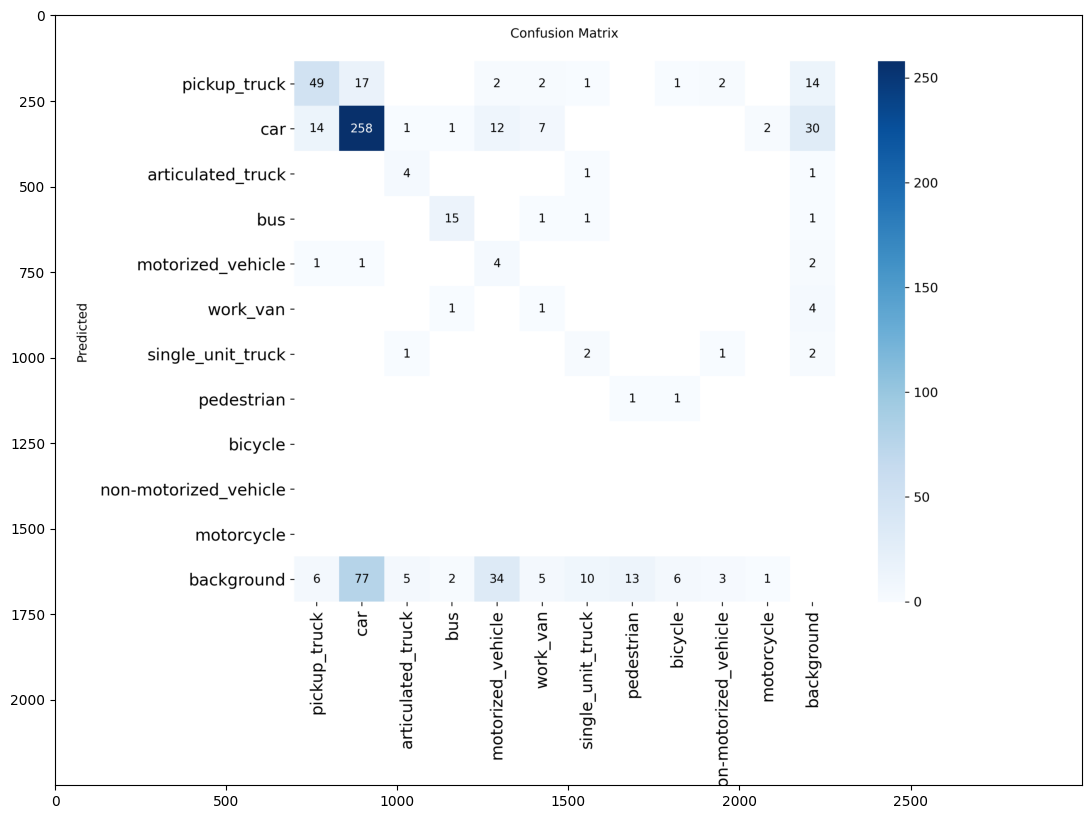

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline 
from PIL import Image 

plt.figure(figsize=(15, 10))
img = Image.open("runs/detect/val/confusion_matrix.png")
plt.imshow(img)

plt.show()

From the above it is clear that maximum vehicles were cars in the 200 validation images.

Plotting some of the batchs to see if the objects were correctly detected

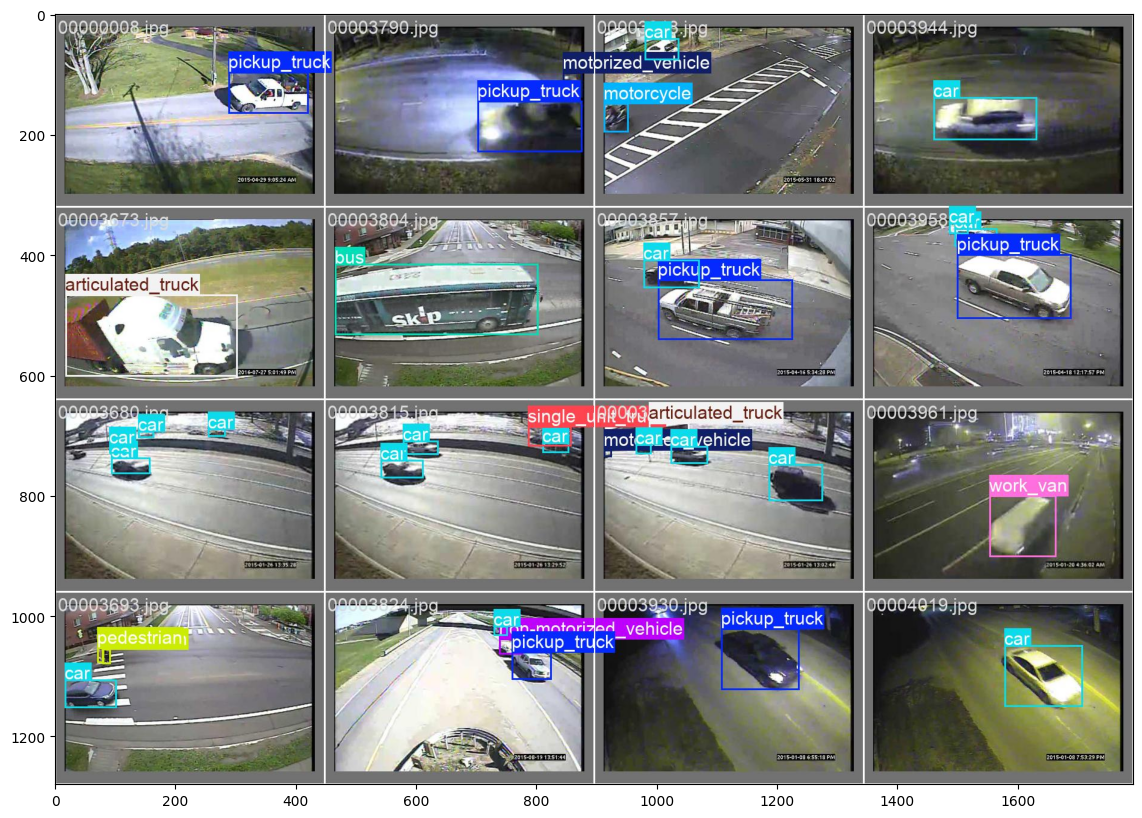

In [48]:
plt.figure(figsize=(15, 10))
img = Image.open("runs/detect/val/val_batch0_labels.jpg")
plt.imshow(img)

plt.show()

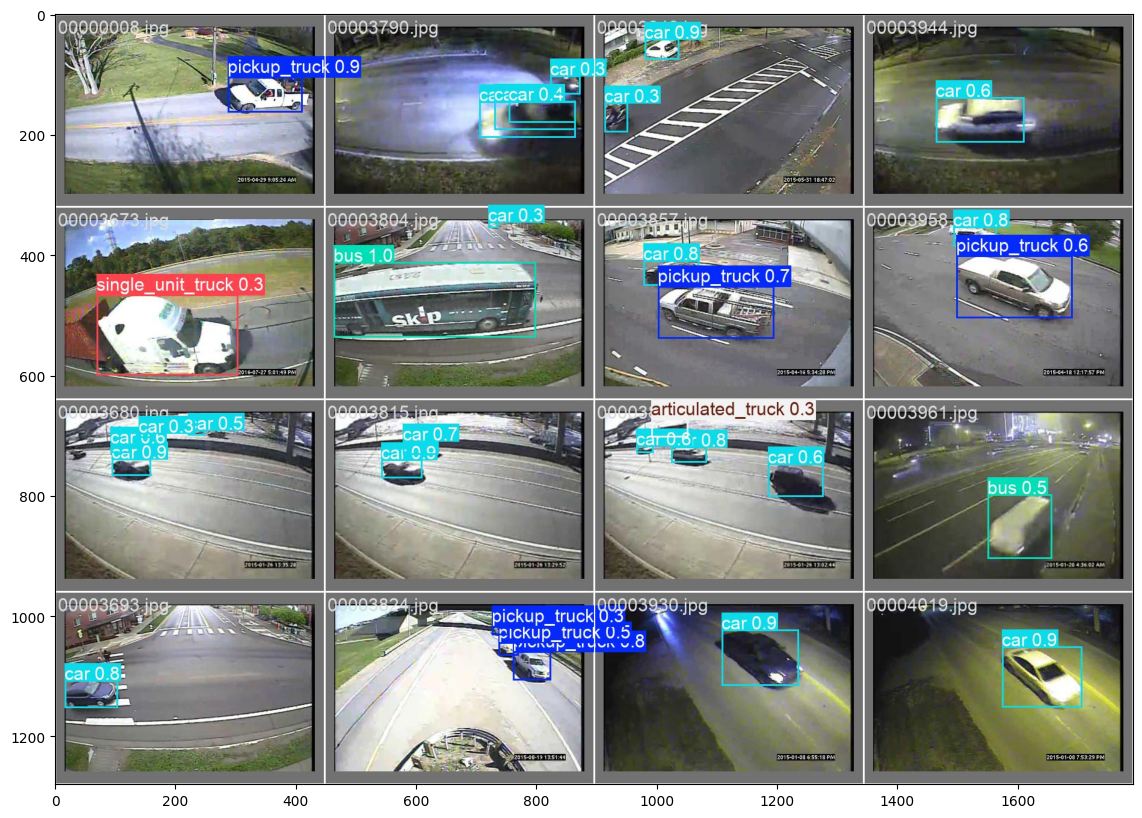

In [49]:
plt.figure(figsize=(15, 10))
img = Image.open("runs/detect/val/val_batch0_pred.jpg")
plt.imshow(img)

plt.show()

### As we can see from the above, not all the predictions were correct. e.g. prediction for 00003824.jpg and 00003930.jg was not entirely correct. 

In [50]:
print("mAP@0.5:", metrics.box.map50)
print("mAP@0.5:0.95:", metrics.box.map)

mAP@0.5: 0.4134645881876722
mAP@0.5:0.95: 0.30164912617253087


 #### mAP@0.5 : Model achieved 41.3% average precision across all object classes when using this relatively lenient localization standard. 
 #### This shows the model has a moderate ability to find and generally locate the objects

#### mAP@0.5:0.95: Model's performance drops to about 30.2% when demanding increasingly precise localization. The significant drop from 0.413 to 0.302 

### Plotting the results

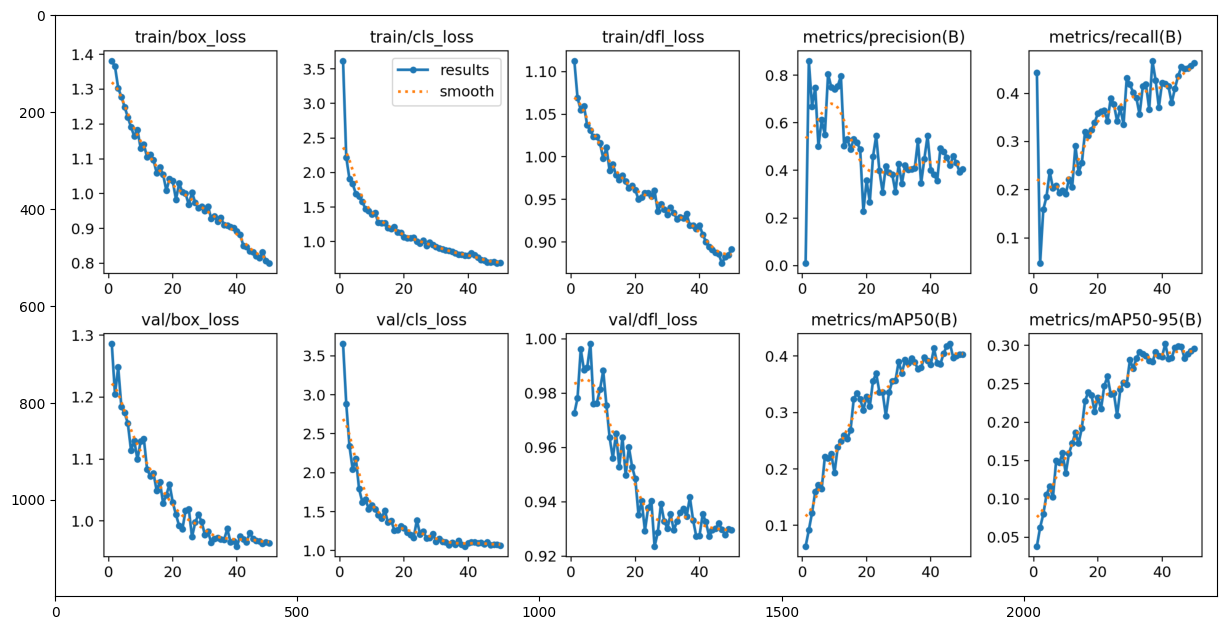

In [52]:
plt.figure(figsize=(15, 10))
img = Image.open("runs/detect/v3_training/results.png")
plt.imshow(img)

plt.show()

#### From above we can see that all the loss curves are decreasing, while the precision, recall, metrics are increasing.

### Training it on a all the data, will help get better object detection and prediction. 

I have trained it on jsut 500 images, because it takes a quite a while and eventually fails on mh system.